#Ejercicio: Algoritmo genético para optimizar un rotor o hélice, paso a paso

##El problema

A menudo, en ingeniería, cuando nos enfrentamos a un problema, no podemos resolver directamente o despejar la solución como en los problemas sencillos típicos de matemáticas o física clásica. Una manera muy típica en la que nos encontraremos los problemas es en la forma de simulación: tenemos una serie de parámetros y un modelo, y podemos simularlo para obtener sus características, pero sin tener ninguna fórmula explícita que relacione parámetros y resultados y que nos permita obtener una función inversa.

En este ejercicio, nos plantearemos un problema de ese tipo: tenemos una función que calcula las propiedades de una hélice en función de una serie de parámetros, pero no conocemos los cálculos que hace internamente. Para nosotros, es una caja negra.

Para optimizar, iremos recuperando las funciones del algoritmo genético que se vieron en la parte de teoría.

In [1]:
%matplotlib inline
import numpy as np # Trabajaremos con arrays
import matplotlib.pyplot as plt # Y vamos a pintar gráficos
from optrot.rotor import calcular_rotor # Esta función es la que vamos a usar para calcular el rotor
import random as random # Necesitaremos números aleatorios

Empecemos echando un ojo a la función del rotor, para ver qué vamos a necesitar y con qué parámetros vamos a trabajar.

In [2]:
help(calcular_rotor)

Help on function calcular_rotor in module optrot.rotor:

calcular_rotor(omega, vz, R, b, h=0, theta0=0.174, tors_param=['h', 14], chord_params=0.05)
    Calcula las propiedades de una hélice. 
    
    Argumentos obligatorios:
    
        - omega: velocidad de giro de la hélice, en rad/s
        - vz: velocidad de avance, en m/s
        - R : radio de la hélice
        - b : número de palas
        
    Argumentos opcionales:
    
        - h : altitud de vuelo, en metros sobre el nivel del mar
        - theta0 : ángulo de paso colectivo
        - tors_param : parámetros de torsión de la hélice:
            formato: [ley, p]
                p: Parámetro: número o lista
                Ley:describe la forma de la ley de torsiones, y puede ser:
                    - 'c': distribución de torsión constante = p
                    - 'l': distribución de torsión lineal, con p[0] en la raíz y p[1] en la punta
                    - 'h': distribución de torsión hiperbólica, con torsión p en la

Podemos trazar unas cuantas curvas para observar qué pinta va a tener lo que saquemos. Por ejemplo, cómo cambian las características de la hélice dependiendo de la velocidad de vuelo, para una hélice de ejemplo que gira a uyna velocidad dada.

In [3]:
vel = np.linspace(0, 30, 100)
efic = np.zeros_like(vel)
T = np.zeros_like(vel)
P = np.zeros_like(vel)
mach = np.zeros_like(vel)
for i in range(len(vel)):
    T[i], P[i], efic[i], mach[i] = calcular_rotor(130, vel[i], 0.5, 3)

Text(0.5,1,'Tracción de la hélice')

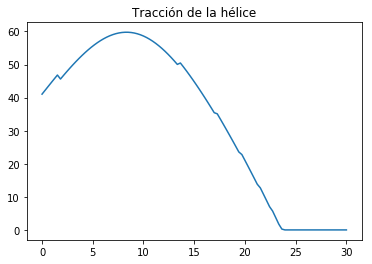

In [4]:
plt.plot(vel, T)
plt.title('Tracción de la hélice')

Text(0.5,1,'Potencia consumida')

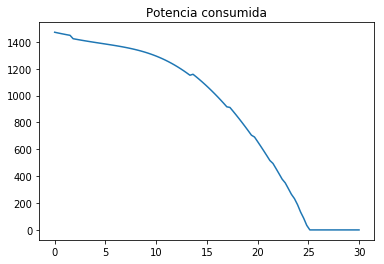

In [5]:
plt.plot(vel, P)
plt.title('Potencia consumida')

Text(0.5,1,'Eficiencia de la hélice')

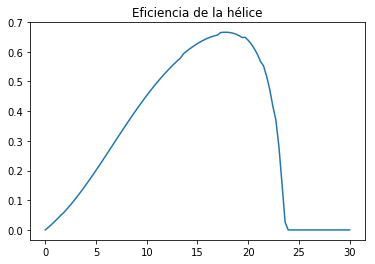

In [6]:
plt.plot(vel, efic)
plt.title('Eficiencia de la hélice')

Text(0.5,1,'Mach en la punta de las palas')

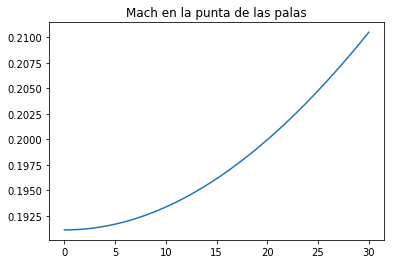

In [7]:
plt.plot(vel, mach)
plt.title('Mach en la punta de las palas')

##Definiendo el genoma

Definamos un individuo genérico: Cada individuo será un posible diseño del rotor, con unas características determinadas.

In [8]:
class Individual (object):
    
    def __init__(self, genome):
        
        self.genome = genome        
        self.traits = {}
        self.performances = {}
        self.fitness = 0

Nuestro rotor depende de varios parámetros, pero en general, buscaremos optimizar el valor de unos, mateniendo un valor controlado de otros. Por ejemplo, la velocidad de avance y la altitud normalmente las impondremos, ya que querremos optimizar para una velocidad y altura de vuelos dadas.

En nuestro algoritmo, usaremos como genoma los parámetros de optimización, y las variables circunstanciales las controlaremos a mano.

***Sugerencia*** (esta es una manera de organizar las variables, aunque puedes escoger otras)

Parámetros de optimización: 

- omega (velocidad de rotación) (Entre 0 y 200 radianes/segundo)
- R (radio de la hélice) (Entre 0.1 y 2 metros)
- b (número de palas) (Entre 2 y 5 palas) 
- theta0 (ángulo de paso colectivo) (Entre -0.26 y 0.26 radianes)(*se corresponde a -15 y 15 grados*)
- p (parámetro de torsión) (Entre -5 y 20 grados)
- cuerda (anchura de la pala) (Entre 0.01 y 0.2 metros)

Parámetros circunstanciales:

- vz (velocidad de vuelo)
- h (altura de vuelo)

Variables que se van a mantener

- ley de torsión (hiperbólica)
- formato de chord params: un solo número, para que la anchura sea constante a lo largo de la pala


In [9]:
15 * np.pi / 180


0.2617993877991494

A continuación crearemos un diccionario de genes. En él iremos almacenando los nombres de los parámetros y la cantidad de bits que usaremos para definirlos. Cuantos más bits, más resolución

Ej: 1 bit : 2 valores, 2 bit : 4 valores, 10 bit : 1024 valores

In [10]:
#Completa este diccionario con las variables que hayas elegido y los bits que usarás

dict_genes = {
    'omega' : 10,
    'R': 10,
    'b': 2
}

Ahora, crearemos una función que rellene estos genomas con datos aleatorios:

In [11]:
def generate_genome (dict_genes):
    
    #Calculamos el número total de bits con un bucle que recorra el diccionario
    
    n_bits = ?
    
    #Generamos un array aletorio de 1 y 0 de esa longitud con numpy
    genome = np.random.randint(0, 2, nbits)
    
    #Transformamos el array en una lista antes de devolverlo
    return list(genome)

SyntaxError: invalid syntax (<ipython-input-11-0b5fab63ae7d>, line 5)

In [ ]:
# Podemos probar a usar nuestra función, para ver qué pinta tiene el ADN de un rotor:
generate_genome(dict_genes)

##Trabajando con el individuo

Ahora necesitamos una función que transforme esos genes a valores con sentido. Cada gen es un número binario cuyo valor estará entre 0 y 2 ^ n, siendo n el número de bits que hayamos escogido. Estas variables traducidas las guardaremos en otro diccionario, ya con su valor. Estos genes no están volando por ahí sueltos, sino que estarán guardados en el interior del individuo al que pertenezcan, por lo que la función deberá estar preparada para extraerlos del individuo, y guardar los resultados a su vez en el interior del individuo.



In [ ]:
def calculate_traits (individual, dict_genes):
    
   
    genome = individual.genome 
    
    integer_temporal_list = []
    
    for gen in dict_genes: #Recorremos el diccionario de genes para ir traduciendo del binario
        
        ??? #Buscamos los bits que se corresponden al bit en cuestión
        
        ??? #Pasamos de lista binaria a número entero
        
        integer_temporal_list.append(??) #Añadimos el entero a la lista
    
    # Transformamos cada entero en una variable con sentido físico:
    # Por ejemplo, si el entero de la variable Omega está entre 0 y 1023 (10bits), 
    # pero la variable Omega real estará entre 0 y 200 radianes por segundo:
    omega = integer_temporal_list[0] * 200 / 1023
    
    #del mismo modo, para R:
    R =  0.1 + integer_temporal_list[1] * 1.9 / 1023 #Obtendremos un radio entre 0.1 y 2 metros
    
    #El número de palas debe ser un entero, hay que tener cuidado:
    b = integer_temporal_list[2] + 2 #(entre 2 y 5 palas)
    
    #Continúa con el resto de variables que hayas elegido!
    
    dict_traits = {     #Aquí iremos guardando los traits, o parámetros  
        'omega' : omega,
        'R': R
    }   
    individual.traits = dict_traits #Por último, guardamos los traits en el individuo

El siguiente paso es usar estos traits(parámetros) para calcular las performances (características o desempeños) del motor. Aquí es donde entra el modelo del motor propiamente dicho. 

In [ ]:
def calculate_performances (individual):
    dict_traits = individual.traits
    
    #Nuestras circunstancias las podemos imponer aquí, o irlas pasando como argumento a la función
    h = 2000 #Altitud de vuelo en metros
    vz = 70  #velocidad de avance en m/s, unos 250 km/h
    
    #Extraemos los traits del diccionario:
    omega = dict_traits['omega']
    R = dict_traits['R']
    #... etc
    
    T, P, efic, mach_punta = calcular_rotor(omega, vz, R, b, h...) #Introduce las variables que uses de parámetro.
                                                                # Consulta la ayuda para asegurarte de que usas el 
                                                                # formato correcto!
    dict_perfo = {        
        'T' : T, #Tracción de la hélice
        'P' : P, #Potencia consumida por la hélice
        'efic': efic, #Eficiencia propulsiva de la hélice
        'mach_punta': mach_punta #Mach en la punta de las palas
    }
    
    individual.performances = dict_perfo

Comprobemos si todo funciona!

In [ ]:
individuo = Individual(generate_genome(dict_genes))
calculate_traits(individuo, dict_genes)
calculate_performances(individuo)

print(individuo.traits)
print(individuo.performances)

El último paso que tenemos que realizar sobre el individuo es uno de los más críticos: Transformar las performances en un valor único (fitness) que con exprese cómo de bueno es con respecto al objetivo de optimización. La función de fitness puede ser función de parámetros(traits) y performances, dependiendo de qué queramos optimizar.

Por ejemplo, si buscáramos que tuviera la tracción máxima sin preocuparnos de nada más, el valor de fitnes sería simplemente igual al de T:

    fitness = T

Si queremos imponer restricciones, por ejemplo, que la potencia sea menor a 1000 watios, se pueden añadir sentencias del tipo:

    if P > 1000:
        fitness -= 1000
        
Se puede hacer depender la fitness de varios parámetros de manera ponderada:

    fitness = parámetro_importante * 10 + parámetro_poco_importante * 0.5
    
También se pueden combinar diferentes funciones no lineales:

    fitness = parámetro_1 * parámetro_2 - parámetro_3 **2 * log(parámetro_4)

Ahora te toca ser creativo! Elige con qué objetivo quieres optimizar la hélice!

Sugerencias de posibles objetivos de optimización:

- Mínimo radio posible, manteniendo una tracción mínima de 30 Newtons
- Mínima potencia posible, máxima eficiencia, y mínimo radio posible en menor medida, manteniendo una tracción mínima de 40 Newtons y un mach en la punta de las palas de como mucho 0.7
- Mínima potencia posible y máxima eficiencia cuando vuela a 70 m/s, tracción mayor a 50 Newtons en el despegue (vz = 0), mínimo peso posible (calculado a partir del radio, número y anchura de las palas) (Puede que tengas que reescribir la función y el diccionario de performances!)

In [ ]:
def calculate_fitness (individual):
    
    dict_traits = individuo.traits
    dict_performances = individuo.performances
    
    fitness = ????? #Be Creative!
    
    
    individual.fitness = fitness

Ya tenemos terminado todo lo que necesitamos a nivel de individuo!

## Que comiencen los Juegos!

Es hora de trabajar a nivel de algoritmo, y para ello, lo primero es crear una sociedad compuesta de individuos aleatorios. Definamos una función para ello.

In [ ]:
def immigration (society, target_population, dict_genes):
    
    while len(society) < target_population:
        
        new_individual = Individual (generate_genome (dict_genes)) # Generamos un individuo aleatorio
        calculate_traits (new_individual, dict_genes) # Calculamos sus traits
        calculate_performances (new_individual) # Calculamos sus performances
        calculate_fitness (new_individual) # Calculamos su fitness
        
        society.append (new_individual) # Nuestro nuevo ciudadano está listo para unirse al grupo! 

Ahora podemos crear nuestra sociedad:

In [ ]:
society = []
immigration (society, 12, dict_genes) #12 por ejemplo, pueden ser los que sean


#Veamos qué pinta tienen los genes de la población
plt.matshow([individual.genome for individual in society], cmap=plt.cm.gray)

Ya tenemos nuestra pequeña sociedad, aumentémosla un poco más mezclando entre sí a los ciudadanos con mejores fitness! Vamos a extender nuestra población mezclando los genomas de otros individuos. Los individuos con mejor fitness es más probable que se reproduzcan. Además, en los nuevos individuos produciremos ligeras mutaciones aleatorias.

In [ ]:
#This function was taken from Eli Bendersky's website
#It returns an index of a list called "weights", 
#where the content of each element in "weights" is the probability of this index to be returned.
#For this function to be as fast as possible we need to pass it a list of weights in descending order.
def weighted_choice_sub(weights):
    
    rnd = random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i

def crossover (society, reproduction_rate, mutation_rate):
    
    #First we create a list with the fitness values of every individual in the society
    fitness_list = [individual.fitness for individual in society]
    
    #We sort the individuals in the society in descending order of fitness.   
    society_sorted = [x for (y, x) in sorted(zip(fitness_list, society), key=lambda x: x[0], reverse=True)] 
    
    #We then create a list of relative probabilities in descending order, 
    #so that the fittest individual in the society has N times more chances to reproduce than the least fit,
    #where N is the number of individuals in the society.
    probability = [i for i in reversed(range(1,len(society_sorted)+1))]
    
    #We create a list of weights with the probabilities of non-mutation and mutation
    mutation = [1 - mutation_rate, mutation_rate]    
    
    #For every new individual to be created through reproduction:
    for i in range (int(len(society) * reproduction_rate)):
        
        #We select two parents randomly, using the list of probabilities in "probability".
        father, mother = society_sorted[weighted_choice_sub(probability)], society_sorted[weighted_choice_sub(probability)]
        
        #We randomly select two cutting points for the genome.
        a, b = random.randrange(0, len(father.genome)), random.randrange(0, len(father.genome))
        
        #And we create the genome of the child putting together the genome slices of the parents in the cutting points.
        child_genome = father.genome[0:min(a,b)]+mother.genome[min(a,b):max(a,b)]+father.genome[max(a,b):]
        
        #For every bit in the not-yet-born child, we generate a list containing 
        #1's in the positions where the genome must mutate (i.e. the bit must switch its value)
        #and 0's in the positions where the genome must stay the same.
        n = [weighted_choice_sub(mutation) for ii in range(len(child_genome))]
        
        #This line switches the bits of the genome of the child that must mutate.
        mutant_child_genome = [abs(n[i] -  child_genome[i]) for i in range(len(child_genome))]
        
        #We finally append the newborn individual to the society
        newborn = Individual(mutant_child_genome)
        calculate_traits (newborn, dict_genes)
        calculate_performances (newborn)
        calculate_fitness (newborn)
        society.append(newborn)     

Ahora que tenemos una sociedad extensa, es el momento de que actúe la selección "natural": Eliminaremos de la sociedad a los individuos con peor fitness hasta llegar a una población objetivo.

In [ ]:
def tournament(society, target_population):
    
    while len(society) > target_population:
            
        fitness_list = [individual.fitness for individual in society]
        society.pop(fitness_list.index(min(fitness_list)))

Ya tenemos nuestro algoritmo prácticamente terminado!

In [ ]:
society = []
fitness_max = []

for generation in range(30):
    
    immigration (society, 100, dict_genes) #Añade individuos aleatorios a la sociedad hasta tener 100
    fitness_max += [max([individual.fitness for individual in society])]
    
    tournament (society, 15) #Los hace competir hasta que quedan 15
    crossover(society, 5, 0.05) #Los ganadores se reproducen hasta tener 75
    
    
plt.plot(fitness_max)
plt.title('Evolución del valor de fitness')

tournament (society, 1) #Buscamos el mejor de todos
winner = society[0]

print(winner.traits) #Comprobamos sus características
print(winner.performances)
